FileNotFoundError: [Errno 2] No such file or directory: '/media/hieunguyen/HNSD_mini/outdir/TMD450_TCGA_data_analysis/20240910/08_output/Liver/thres_hypo_0.3_hyper_0.6/ratio_raw_boxplot.svg'

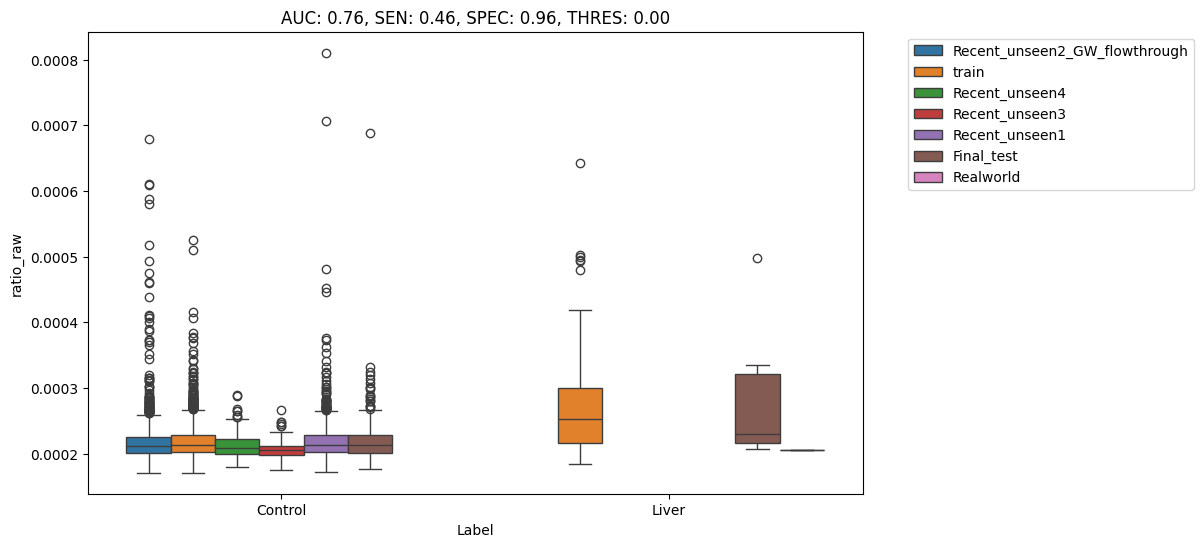

In [1]:
import pandas as pd
import numpy as np
import pathlib 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
import warnings
import pandas as pd
from sklearn.metrics import roc_curve, auc

warnings.filterwarnings('ignore')

data_version = "TMD_cov"
output_version = "20240910"

outdir = "/media/hieunguyen/HNSD_mini/outdir"
PROJECT = "TMD450_TCGA_data_analysis"
thres_hypo = 0.3
thres_hyper = 0.6

input_cancer_class = "Liver"
path_to_main_output = os.path.join(outdir, PROJECT, output_version)
path_to_03_output = os.path.join(path_to_main_output, "03_output", input_cancer_class)
path_to_07_output = os.path.join(outdir, PROJECT, output_version, "07_output", input_cancer_class, "thres_hypo_{}_hyper_{}".format(thres_hypo, thres_hyper))
path_to_08_output = os.path.join(outdir, PROJECT, output_version, "08_output", input_cancer_class, "thres_hypo_{}_hyper_{}".format(thres_hypo, thres_hyper))

os.system(f"mkdir -p {path_to_08_output}")

metadata = pd.read_excel("metadata_cfDNA_lowpdepth_TMD_bam_cov.xlsx")
metadata = metadata[metadata["Label"].isin([input_cancer_class, "Control"])]

all_files = [item for item in pathlib.Path(path_to_07_output).glob("*.candi_reads.csv")]
countdf = pd.read_csv(os.path.join(path_to_07_output, "all_count.csv"), index_col = [0])

all_samples = []
all_mean_candi_reads = []
for file in all_files:
    tmpdf = pd.read_csv(file)
    mean_candi_reads = tmpdf.candi_reads.mean()
    all_samples.append(file.name.split(".")[0])
    all_mean_candi_reads.append(mean_candi_reads)

candidf = pd.DataFrame({"SampleID": all_samples, "num_candi_reads": all_mean_candi_reads})
candidf = candidf.merge(countdf, right_on = "SampleID", left_on = "SampleID")
candidf["ratio_raw"] = candidf["num_candi_reads"] / candidf["raw_count"]
candidf["ratio_in_reads"] = candidf["num_candi_reads"] / candidf["in_read_count"]
candidf = candidf.merge(metadata[["SampleID", "Label", "Set"]], right_on = "SampleID", left_on = "SampleID")


# Calculate the ROC curve for the values ratio_raw
fpr_ratio_raw, tpr_ratio_raw, thres_ratio_raw = roc_curve(candidf['Label'].apply(lambda x: 1 if x == input_cancer_class else 0), candidf['ratio_raw'])
aucdf = pd.DataFrame({"fpr": fpr_ratio_raw, "tpr": tpr_ratio_raw, "thres": thres_ratio_raw})
aucdf_95 = aucdf[aucdf["fpr"] <= 0.05]

selected_thres_ratio_raw = aucdf_95[aucdf_95["tpr"] == aucdf_95["tpr"].max()].thres.values[0]
selected_spec_ratio_raw = 1 - aucdf_95[aucdf_95["tpr"] == aucdf_95["tpr"].max()].fpr.values[0]
selected_sens_ratio_raw = aucdf_95[aucdf_95["tpr"] == aucdf_95["tpr"].max()].tpr.values[0]

# Calculate the AUC
roc_auc = auc(fpr_ratio_raw, tpr_ratio_raw)
title_raw = f"AUC: {roc_auc:.2f}, SEN: {selected_sens_ratio_raw:.2f}, SPEC: {selected_spec_ratio_raw:.2f}, THRES: {selected_thres_ratio_raw:.2f}"

# Calculate the ROC curve for the values ratio_in_reads
fpr_ratio_in_reads, tpr_ratio_in_reads, thres_ratio_in_reads = roc_curve(candidf['Label'].apply(lambda x: 1 if x == input_cancer_class else 0), candidf['ratio_in_reads'])
aucdf = pd.DataFrame({"fpr": fpr_ratio_in_reads, "tpr": tpr_ratio_in_reads, "thres": thres_ratio_in_reads})
aucdf_95 = aucdf[aucdf["fpr"] <= 0.05]

selected_thres_ratio_in_reads = aucdf_95[aucdf_95["tpr"] == aucdf_95["tpr"].max()].thres.values[0]
selected_spec_ratio_in_reads = 1 - aucdf_95[aucdf_95["tpr"] == aucdf_95["tpr"].max()].fpr.values[0]
selected_sens_ratio_in_reads = aucdf_95[aucdf_95["tpr"] == aucdf_95["tpr"].max()].tpr.values[0]

# Calculate the AUC
roc_auc = auc(fpr_ratio_in_reads, tpr_ratio_in_reads)
title_in_reads = f"AUC: {roc_auc:.2f}, SEN: {selected_sens_ratio_in_reads:.2f}, SPEC: {selected_spec_ratio_in_reads:.2f}, THRES: {selected_thres_ratio_in_reads:.2f}"

plt.figure(figsize=(10, 6))
sns.boxplot(data=candidf, x="Label", y="ratio_raw", hue="Set")
plt.title(title_raw)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig(os.path.join(path_to_08_output, "ratio_raw_boxplot.svg"), format='svg')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=candidf, x="Label", y="ratio_in_reads", hue="Set")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig(os.path.join(path_to_08_output, "ratio_in_reads_boxplot.svg"), format='svg')
plt.title(title_in_reads)
plt.show()